## Import Statements

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import matplotlib.pyplot as plt

### Get subset of yahoo finance data

In [2]:
def get_stock_data(ticker):
    stock = yf.download(ticker)
    return stock.dropna()

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
stock_data = {ticker: get_stock_data(ticker) for ticker in tickers}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### For this stage of the exploration, only work with aapl stock

In [3]:
aapl = stock_data["AAPL"]
aapl.describe

<bound method NDFrame.describe of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.099449   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.094261   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.087343   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.089504   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.092099   
...                ...         ...         ...         ...         ...   
2023-09-14  174.000000  176.100006  173.580002  175.740005  175.740005   
2023-09-15  176.479996  176.500000  173.820007  175.009995  175.009995   
2023-09-18  176.479996  179.380005  176.169998  177.970001  177.970001   
2023-09-19  177.520004  179.630005  177.130005  179.070007  179.070007   
2023-09-20  179.259995  179.699997  175.399994  175.490005  175.490005   

   

In [4]:
aapl_close = aapl["Close"]
full_range = pd.date_range(start=aapl_close.index.min(), end=aapl_close.index.max(), freq='D')
aapl_close = aapl_close.reindex(full_range)
aapl_close.index = pd.DatetimeIndex(aapl_close.index, freq='D')
aapl_close
model = ARIMA(aapl_close, order=(1,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                15623
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -13605.350
Date:                Thu, 21 Sep 2023   AIC                          27218.700
Time:                        16:19:31   BIC                          27249.326
Sample:                    12-12-1980   HQIC                         27228.841
                         - 09-20-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8879      0.007   -134.314      0.000      -0.901      -0.875
ma.L1          0.7638      0.007    105.632      0.000       0.750       0.778
ma.L2         -0.1826      0.003    -61.621      0.000      -0.188      -0.177
sigma2         0.5939      0.002    325.544      0.000       0.590       0.597
===================================================================================
Ljung-Box (L1) (Q):                  38.15   Jarque-Bera (JB):           2969248.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           27669.84   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

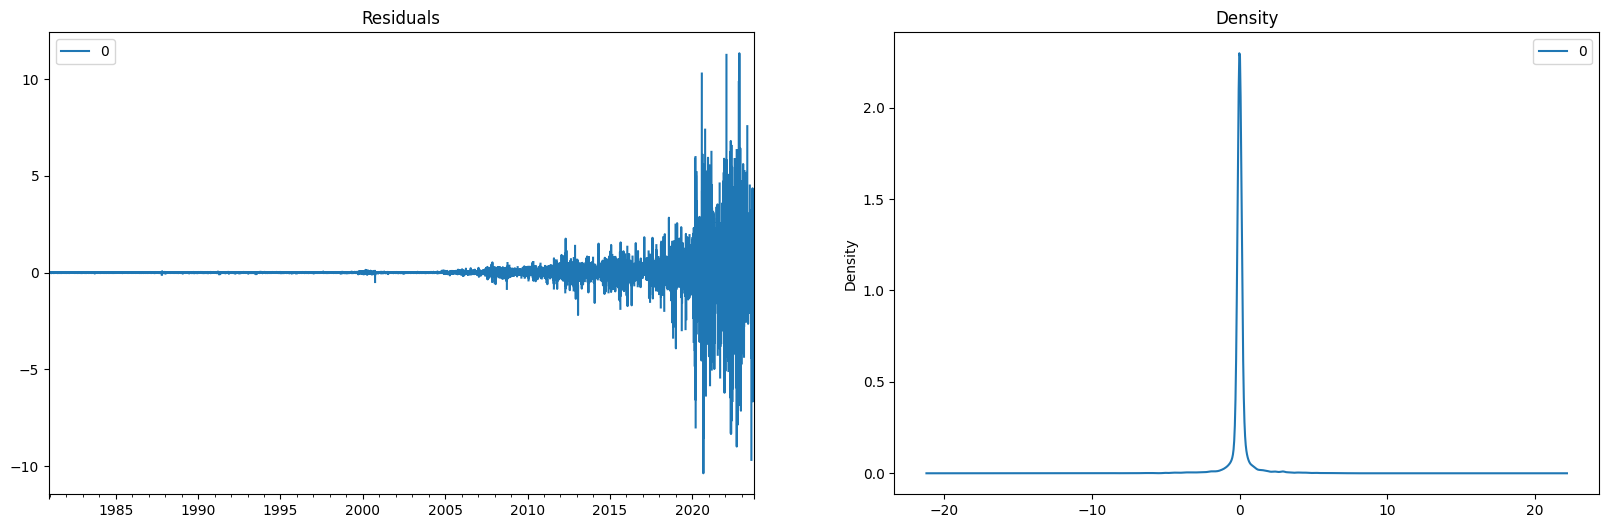

In [28]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize = (20, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

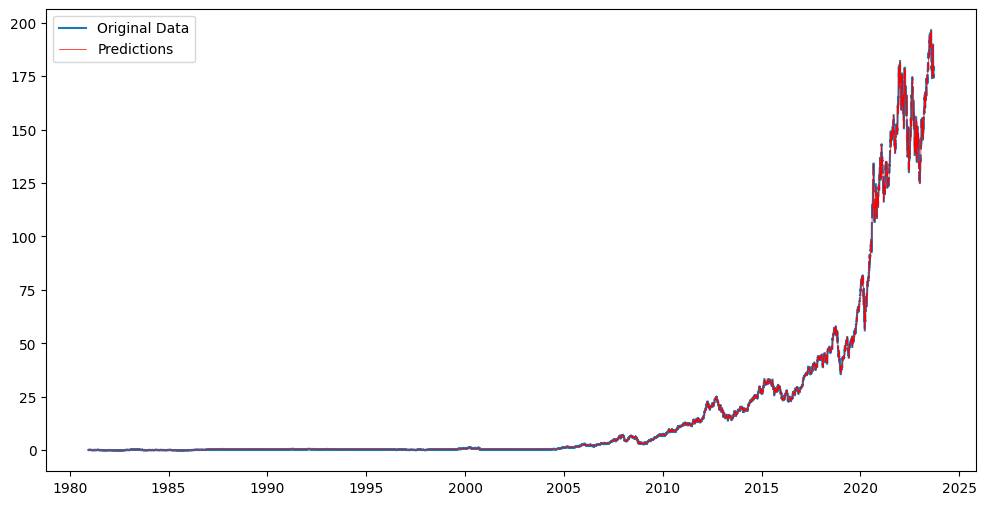

In [8]:
# Actual vs Fitted
predicted = model_fit.predict(start=start_point, end=end_point, dynamic=False)
plt.figure(figsize=(12, 6))
plt.plot(aapl_close, label="Original Data")
plt.plot(predicted, color='red', label="Predictions", lw=0.5)
plt.legend()
plt.show()

### Hyperparameter Tuning for order (p, d, q)

In [2]:
# Function to tune the for p, d, q
def custom_loss(params, *args):
    # Extract arguments
    order = args[0]
    data = args[1]
    
    # Extract AR, I, and MA orders
    p, d, q = order
    
    # Set the parameters of the ARIMA model
    arima_model = ARIMA(data, order=order)
    
    # Fit the ARIMA model
    try:
        result = arima_model.fit(disp=False, start_params=params, method='css-mle')
    except Exception as e:
        # If the model cannot be fitted, return a large loss
        return 1e6
    
    # Calculate the custom loss
    residuals = result.resid
    loss = np.sum(residuals**2)  # Example custom loss (squared residuals)
    
    return loss